# Playground

## Load

In [1]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt
import arviz as az

In [2]:
from m5 import __data__
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [3]:
ds_all = load_ds()
# ds_all = load_ds(recalc=True)
ds = ds_all.where(ds_all['historic'], drop=True)
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic    (date) bool True True True True True ... True True True True
    future      (date) bool False False False False ... False False False False
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

## Model - Unit Sales

### Prepare data

In [4]:
x = (
    ds
    #.sel({"store_id": ["CA_1"]})
    #.isel({"item_id": slice(0,20)})
    #.isel({"date": slice(1500, None)})
    .transpose("date", "item_id", "store_id", "event_name")
)
x

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic    (date) bool True True True True True ... True True True True
    future      (date) bool False False False False ... False False False False
Data variables:
    sales       (date, item_id, store_id) int64 3 2 1 0 0 0 0 ... 0 0 1 2 0 0 0
    price       (date, item_id, store_id) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

In [5]:
d = x.copy()
d["log_price"] = np.log(d["price"]).fillna(0)
d.coords["day_of_week"] = np.arange(7, dtype=int)
d.coords["month_of_year"] = np.arange(12, dtype=int)

ref_date_ns = pd.Timestamp("2010-01-01").to_datetime64().astype(float)
d["date_f"] = (d["date"].astype(float) - ref_date_ns) / 1e15

_sls = d['sales'].sum(dim='item_id')
_sls = _sls.where(_sls > 0)
# d["store_sales"] = _sls.fillna(_sls.mean(dim='date'))

In [6]:
d

<xarray.Dataset>
Dimensions:        (date: 1941, day_of_week: 7, event_name: 30, item_id: 3049, month_of_year: 12, store_id: 10)
Coordinates:
  * item_id        (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id         (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id        (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id       (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
    state_id       (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date           (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name     (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type     (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic       (date) bool True True True True True ... True True True True
    future         (date) bool False False False False ... False False False
  * day_of_week    (day_of_week) int64 0 1 2 3 4 5 6
  * month_of_year  (month_of_year) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    sales          (date, item_id, store_id) int64 3 2 1 0 0 0 0 ... 0 1 2 0 0 0
    price          (date, item_id, store_id) float64 2.0 2.0 2.0 ... 5.94 5.94
    wday           (date) int64 1 2 3 4 5 6 7 1 2 3 4 ... 6 7 1 2 3 4 5 6 7 1 2
    month          (date) int64 1 1 1 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5
    year           (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event          (date, event_name) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    snap           (date, store_id) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    log_price      (date, item_id, store_id) float64 0.6931 0.6931 ... 1.782
    date_f         (date) float64 33.96 34.04 34.13 34.21 ... 201.4 201.5 201.6

### Define model

In [7]:
d.coords["lag"] = np.arange(-1, 0)

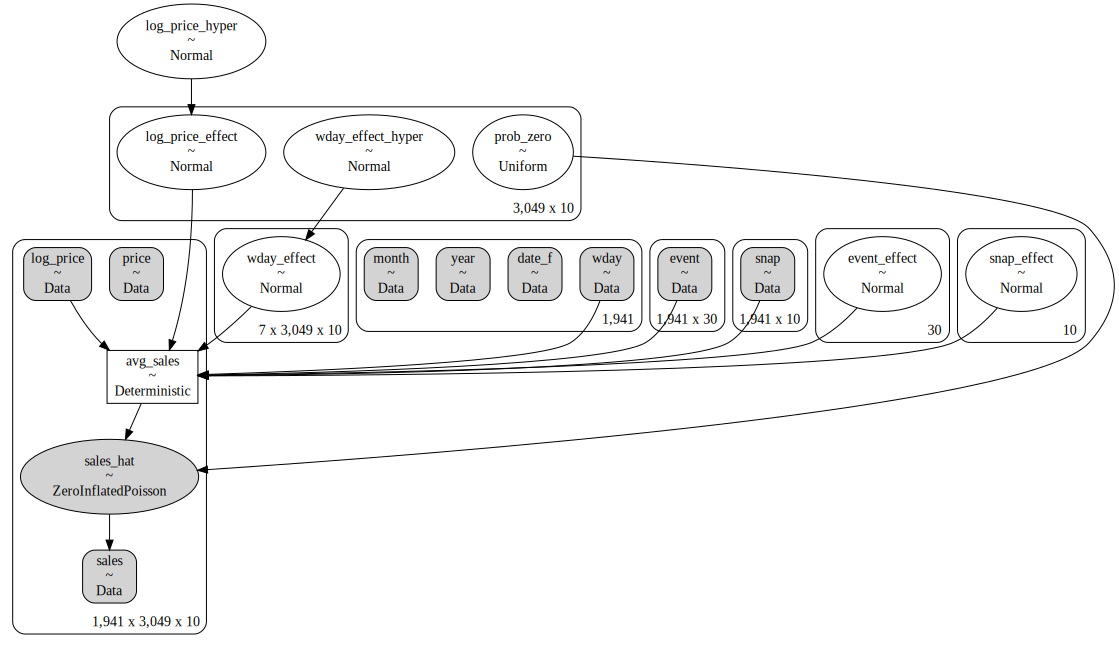

In [8]:
with pm.Model(coords=d.coords) as m:
    for k, v in d.data_vars.items():
        pm.Data(k, v, dims=v.dims)

    pm.Normal("wday_effect_hyper", mu=0, sigma=2, dims=["item_id", "store_id"])
    pm.Normal(
        "wday_effect",
        mu=m["wday_effect_hyper"][np.newaxis, :, :],
        sigma=2,
        dims=["day_of_week", "item_id", "store_id"],
    )

    pm.Normal("event_effect", mu=0, sigma=2, dims=["event_name"])
    pm.Normal("snap_effect", mu=0, sigma=2, dims=["store_id"])

    pm.Normal("log_price_hyper", mu=-1, sigma=1)
    pm.Normal(
        "log_price_effect",
        mu=m["log_price_hyper"][np.newaxis, np.newaxis],
        sigma=1,
        dims=["item_id", "store_id"],
    )
    # pm.Normal("log_price_global_effect", mu=-1, sigma=1)

    pm.Deterministic(
        "avg_sales",
        tt.exp(
            m["wday_effect"][m["wday"] - 1]
            + (m["log_price"] * m["log_price_effect"][np.newaxis, :, :])
            # + (m['log_price'] * m['log_price_global_effect'])
            + (m["event"] @ m["event_effect"])[:, np.newaxis, np.newaxis]
            + (
                m["snap"][:, np.newaxis, :]
                * m["snap_effect"][np.newaxis, np.newaxis, :]
            )
            # + m["ar_process"]
        ),
        dims=["date", "item_id", "store_id"],
    )

    pm.Uniform("prob_zero", 0, 1, dims=["item_id", "store_id"])
    # pm.Deterministic(
    #     "prob_zero",
    #     m["pz_base"][np.newaxis, :, :],
    #     dims=["date", "item_id", "store_id"],
    # )

    pm.ZeroInflatedPoisson(
        "sales_hat",
        psi=m["prob_zero"],
        theta=m["avg_sales"],
        dims=["date", "item_id", "store_id"],
        observed=m["sales"],
    )

try:
    gv = pm.model_to_graphviz(m)
    display(gv)
except Exception as e:
    print(f"Error displaying model:\n{e!r}")

### Fit (or load trace)

In [9]:
path_model = __data__ / "model" / "v1"
path_model.mkdir(exist_ok=True, parents=True)

In [ ]:
if (path_model / "trace.nc").exists():
    trace = az.InferenceData.from_netcdf(path_model / "trace.nc")
else:
    with m:
        trace = pm.sample(
            draws=500,
            tune=300,
            chains=4,
            nuts=dict(target_accept=0.9),
            return_inferencedata=True,
            # init="adapt_diag",
        )
    trace.to_netcdf(path_model / "trace.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


### Check params

In [ ]:
post_mean = trace.posterior.mean(dim=['chain', 'draw'])
post_mean

In [ ]:
# az.plot_trace(trace, var_names=['prob_zero', 'wday_effect_hyper', 'ar_theta', 'ar_tau', ]);
az.plot_trace(trace, var_names=['prob_zero', 'wday_effect_hyper', 'wday_effect' ,'event_effect']);

In [ ]:
post_mean['event_effect'].to_series().sort_values().iloc[[0, 1, 2, 3, -4, -3, -2, -1]]

### Posterior prediction

In [ ]:
with m:
    ppc_raw = pm.fast_sample_posterior_predictive(trace)
    ifd2 = az.from_pymc3(posterior_predictive=ppc_raw)
ppc = ifd2.posterior_predictive

### Low-level plots

In [ ]:
_raw = ppc["sales_hat"]
q = xr.Dataset(
    {
        "actual": d["sales"],
        # "raw": _raw,
        "mean": _raw.mean(dim=["chain", "draw"]),
        "median": _raw.median(dim=["chain", "draw"]),
        "nonzero_avg_sales": trace.posterior['avg_sales'].mean(dim=['chain', 'draw'])
    }
)
for iw in [50, 90, 99]:
    h = az.hdi(_raw, hdi_prob=iw/100)["sales_hat"].to_dataset(dim="hdi")
    h = h.rename({"lower": f"lower_{iw}", "higher": f"higher_{iw}"})
    q = q.merge(h)

In [ ]:
n_stores = min(5, len(q['store_id']))
n_items = min(10, len(q['item_id']))

fig, axs = plt.subplots(n_items, n_stores, squeeze=False, figsize=(14, 6 * n_items))
for i_item in range(n_items):
    for i_store in range(n_stores):
        _item = q['item_id'].values[i_item]
        _store = q['store_id'].values[i_store]
        
        ax = axs[i_item, i_store]
        ax.set_title(f"Item {_item}, Store {_store}")

        _q = q.isel({"store_id": i_store, "item_id": i_item})
        _df = _q.to_dataframe()[list(_q.data_vars)]
        
        _df['actual'].plot(ax=ax, color='C0')
        # _df['median'].plot(ax=ax, color='C1')
        ax.fill_between(_df.index, _df['lower_50'], _df['higher_50'], alpha=0.3, color='C1', label='50% CI')
        ax.fill_between(_df.index, _df['lower_99'], _df['higher_99'], alpha=0.2, color='C2', label='99% CI')
        _df['mean'].plot(ax=ax, color='C2')
        # _df['nonzero_avg_sales'].plot(ax=ax, color='C3', alpha=0.4)
        ax.legend()
fig;

### Aggregate plot

In [ ]:
_raw1 = ppc["sales_hat"].sum(dim=["item_id", "store_id"])
a = xr.Dataset(
    {
        "actual": d["sales"].sum(dim=["item_id", "store_id"]),
        # "raw": _raw,
        "mean": _raw1.mean(dim=["chain", "draw"]),
        "median": _raw1.median(dim=["chain", "draw"]),
        "nonzero_avg_sales": (
            trace.posterior["avg_sales"]
            .sum(dim=["item_id", "store_id"])
            .mean(dim=["chain", "draw"])
        ),
    }
)
for iw in [50, 90, 99]:
    h = az.hdi(_raw1, hdi_prob=iw / 100)["sales_hat"].to_dataset(dim="hdi")
    h = h.rename({"lower": f"lower_{iw}", "higher": f"higher_{iw}"})
    a = a.merge(h)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title("Total sales")

_df = a.to_dataframe()[list(a.data_vars)]

_df['actual'].plot(ax=ax, color='C0')
# _df['median'].plot(ax=ax, color='C1')
ax.fill_between(_df.index, _df['lower_50'], _df['higher_50'], alpha=0.3, color='C1', label='50% CI')
ax.fill_between(_df.index, _df['lower_99'], _df['higher_99'], alpha=0.2, color='C2', label='99% CI')
_df['mean'].plot(ax=ax, color='C2')
# _df['nonzero_avg_sales'].plot(ax=ax, color='C3', alpha=0.4)
ax.legend()
fig;